In [1]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import os
from IPython.display import display, Image
from scipy.io import loadmat
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle
%matplotlib inline

In [2]:
# Download the cropped SVHN dataset in .mat format.
# These contain 32x32 images with single-digit labels for each image.
url = 'http://ufldl.stanford.edu/housenumbers/'

def maybe_download(filename, force=False):
    # Download a file if not present
    if force or not os.path.exists(filename):
        filename, _ = urlretrieve(url + filename, filename)
        statinfo = os.stat(filename)
        return filename

train_filename = maybe_download('train_32x32.mat')
test_filename = maybe_download('test_32x32.mat')
extra_filename = maybe_download('extra_32x32.mat')

In [2]:
# Load dataset.

# Load .mat files
train_mat = loadmat('train_32x32.mat')
test_mat = loadmat('test_32x32.mat')
extra_mat = loadmat('extra_32x32.mat')

# Get features and labels for train and test datasets.
train_features = train_mat['X']
train_labels = train_mat['y']
test_features = test_mat['X']
test_labels = test_mat['y']
extra_features = extra_mat['X']
extra_labels = extra_mat['y']

print ("train_mat dimensions:", train_features.shape, train_labels.shape)
print ("test_mat dimensions:", test_features.shape, test_labels.shape)
print ("extra_mat dimensions:", extra_features.shape, extra_labels.shape)

# Set train labels of class index 10 to represent number label '0'
train_labels[train_labels == 10] = 0
test_labels[test_labels == 10] = 0
extra_labels[extra_labels ==10] = 0

('train_mat dimensions:', (32, 32, 3, 73257), (73257, 1))
('test_mat dimensions:', (32, 32, 3, 26032), (26032, 1))
('extra_mat dimensions:', (32, 32, 3, 531131), (531131, 1))


In [3]:
# Build a validation set from the training set and testing set.
# 2000 samples are taken from the training set and 4000 samples are taken from the extra set.
# These are combined to provide 6000 samples for the validation set.
# Note: For scikit-learn version 0.18 and later, import sklearn.model_selection instead of sklearn.cross_validation 

from sklearn.cross_validation import StratifiedShuffleSplit

sss_1 = StratifiedShuffleSplit(train_labels, test_size=2000, random_state=42)

sss_2 = StratifiedShuffleSplit(extra_labels, test_size=4001, random_state=42)

for train_index, valid_index in sss_1:
    X_train, X_valid_1 = train_features[:,:,:,train_index], train_features[:,:,:,valid_index]
    y_train, y_valid_1 = train_labels[train_index], train_labels[valid_index]

for extra_index, valid_index in sss_2:
    X_extra, X_valid_2 = extra_features[:,:,:,extra_index], extra_features[:,:,:,valid_index]
    y_extra, y_valid_2 = extra_labels[extra_index], extra_labels[valid_index]

X_valid = np.concatenate((X_valid_1, X_valid_2), axis=3).transpose((3,0,1,2))
y_valid = np.concatenate((y_valid_1, y_valid_2), axis=0)[:,0]
X_train = X_train.transpose((3,0,1,2))
y_train = y_train[:,0]
X_test = test_features.transpose((3,0,1,2))
y_test = test_labels[:,0]
    
print ("Training set dimensions:", X_train.shape, y_train.shape)
print ("Validation set dimensions:", X_valid.shape, y_valid.shape)
print ("Testing set dimensions:", X_test.shape, y_test.shape)

('Training set dimensions:', (71257, 32, 32, 3), (71257,))
('Validation set dimensions:', (6000, 32, 32, 3), (6000,))
('Testing set dimensions:', (26032, 32, 32, 3), (26032,))


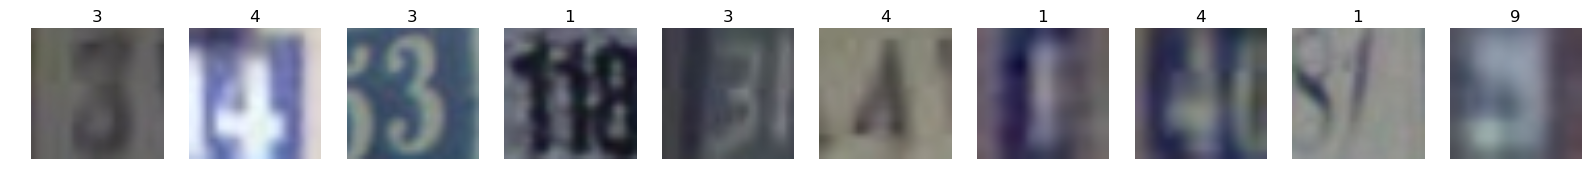

In [15]:
# Plot a selection of 10 random samples from training set.

plt.rcParams['figure.figsize'] = (20.0, 20.0)
f, ax = plt.subplots(nrows=1, ncols=10)

for i, j in enumerate(np.random.randint(0, y_train.shape[0], size=10)):
    ax[i].axis('off')
    ax[i].set_title(y_train[j], loc='center')
    ax[i].imshow(X_train[j,:,:])

In [4]:
# Convert images to grayscale. This uses the weighted average method.

def rgb2gray(image):
    r, g, b = image[:,:,:,0], image[:,:,:,1], image[:,:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
    return gray

X_train_gs = rgb2gray(X_train)
X_valid_gs = rgb2gray(X_valid) 
X_test_gs = rgb2gray(X_test)

print("Training set dimensions:", X_train_gs.shape, y_train.shape)
print("Validation set dimensions:", X_valid_gs.shape, y_valid.shape)
print("Testing set dimensions:", X_test_gs.shape, y_test.shape)

('Training set dimensions:', (71257, 32, 32), (71257,))
('Validation set dimensions:', (6000, 32, 32), (6000,))
('Testing set dimensions:', (26032, 32, 32), (26032,))


In [5]:
# Apply Global Contrast Normalization.
# A very small value of epsilon = 1e-8 is multiplied by the standard deviation to avoid division-by-zero errors.

def GCN(image, epsilon=1e-8):
    mean = np.mean(image)
    std = np.std(image)
    for i in range(image.shape[0]):
        image[i,:,:] = (image[i,:,:] - mean) / (epsilon * std)
        return image

X_train_gcn = GCN(X_train_gs)
X_valid_gcn = GCN(X_valid_gs) 
X_test_gcn = GCN(X_test_gs)

print("Training set dimensions:", X_train_gcn.shape, y_train.shape)
print("Validation set dimensions:", X_valid_gcn.shape, y_valid.shape)
print("Testing set dimensions:", X_test_gcn.shape, y_test.shape)

('Training set dimensions:', (71257, 32, 32), (71257,))
('Validation set dimensions:', (6000, 32, 32), (6000,))
('Testing set dimensions:', (26032, 32, 32), (26032,))


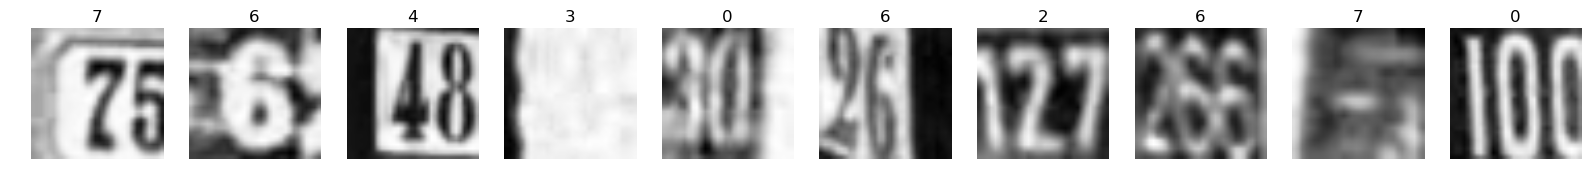

In [18]:
# Plot 10 samples of preprocessed images from training set.

plt.rcParams['figure.figsize'] = (20.0, 20.0)
f, ax = plt.subplots(nrows=1, ncols=10)

for i, j in enumerate(np.random.randint(0, y_train.shape[0], size=10)):
    ax[i].axis('off')
    ax[i].set_title(y_train[j], loc='center')
    ax[i].imshow(X_train_gcn[j,:,:], cmap='Greys')

In [6]:
# Save to pickle file for later reuse.

pickle_file = 'SVHN_single.pickle'

try:
    f = open(pickle_file, 'wb')
    save = {
    'train_features': X_train_gcn,
    'train_labels': y_train,
    'valid_features': X_valid_gcn,
    'valid_labels': y_valid,
    'test_features': X_test_gcn,
    'test_labels': y_test,
    }
    pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
    f.close()
except Exception as e:
    print('Unable to save data to', pickle_file, ':', e)
    raise
    
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

('Compressed pickle size:', 846247221)
